<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Import-Stuff" data-toc-modified-id="Import-Stuff-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Stuff</a></span></li><li><span><a href="#Some-Anonymous-Functions" data-toc-modified-id="Some-Anonymous-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Some Anonymous Functions</a></span></li><li><span><a href="#Named-Functions" data-toc-modified-id="Named-Functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Named Functions</a></span></li></ul></li><li><span><a href="#Dipole-Populations" data-toc-modified-id="Dipole-Populations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dipole Populations</a></span><ul class="toc-item"><li><span><a href="#Average-Dipole-vs-Fill" data-toc-modified-id="Average-Dipole-vs-Fill-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Average Dipole vs Fill</a></span></li><li><span><a href="#Oxygen-Partial-Charge-vs-Fill" data-toc-modified-id="Oxygen-Partial-Charge-vs-Fill-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Oxygen Partial Charge vs Fill</a></span></li></ul></li></ul></div>

# Setup

## Import Stuff

In [1]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as GS
import numpy as np
import seaborn as sns
%matplotlib inline

sns.set(font_scale=1.5)

vacuum_df = pkl.load(open('tidy_data/vacuum.pkl','rb'))
beryl_df = pkl.load(open('tidy_data/beryl.pkl','rb'))
vacuum_df.head()

,config,couple,fill,run,type,value
0,0,ferro,1000,0,dipole,1.850388
1,0,ferro,1000,0,total_dipole,1.850388
2,0,ferro,1000,4,dipole,1.853036
3,0,ferro,1000,4,total_dipole,1.853036
4,0,ferro,1000,6,dipole,1.852495


## Some Anonymous Functions

In [2]:
filter_by_fill = lambda fill,df: df[df.fill == fill]
filter_by_couple = (lambda couple,df: df[df.couple == couple]
                    .sort_values(["config","run"],axis=0))
                   # .set_index(["config"]))
filter_by_config = lambda config,df: df[df.config == config]
filter_by_type = lambda type_,df: df[df.type == type_]
flatten = lambda x: [j for i in x for j in i]
get_dipoles = lambda df: flatten(df.dipoles.values)
get_total_dipole = lambda df: df.total_dipole.values

drop_outliers = lambda df: df.drop(df.index[return_outliers(df.total_dipole)])

## Named Functions

In [3]:
def reject_outliers(data, m = 1.):
        '''Used modified Z-score itl.nist.gov/div898/handbook/eda/section3/eda35h.htm '''
        data = np.array(data)
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    
def return_outliers(data, m = 1.0):
    '''Used modified Z-score itl.nist.gov/div898/handbook/eda/section3/eda35h.htm '''
    data = np.array(data)
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    reject = list(data[s>=m])
    return [list(data).index(i) for i in reject]


def get_fill_df(couple,fill,m=1.0):   
    entries = []
    for config in list(set(raw_df.config.values)):
        
        try:
            df = filter_by_config(config,filter_by_couple(couple,filter_by_fill(fill,raw_df)))
            dipoles = get_dipoles(df)
            total_dipole = get_total_dipole(df)
            df = drop_outliers(df)
            clean_dipoles = get_dipoles(df)
            clean_total_dipole = get_total_dipole(df)

            entry = {'couple':couple, 'fill':fill, 'config':config, 
                     'raw_dipoles':dipoles,'clean_dipoles':clean_dipoles,
                     'raw_total_dipole':total_dipole,'clean_total_dipole':clean_total_dipole}

            entries.append(entry)
        except:
            print("Error: {} {} {} ".format(couple,fill,config))
        
    return pd.DataFrame(entries)



def make_dipole_plots():



    fig = plt.figure(figsize=(12,5))

    gs = GS.GridSpec(nrows=1,ncols=2,figure=fig,hspace=0.6)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    #ax3 = plt.subplot(gs[2:,:])

    #fig.suptitle("Dipole Analysis\nFill: {}".format(fill),fontsize=16)
    for j,tidy_df in enumerate([vacuum_df,beryl_df]):
        for fill in [1000,1010,1100,1110,1111]:
            df = filter_by_fill(fill,tidy_df)
            df_d = filter_by_type('dipole',df)
            df_td = filter_by_type('total_dipole',df)
            # Dipole by Configuratio
            #for i in np.arange(60):
            #    config = filter_by_config(i,df_d)
            #    sns.kdeplot(config.value.values,ax=ax1)


            # Dipole and Total Dipole all Configurations
            label = 'Vacuum' if j == 0 else 'Beryl'
            ax = ax1 if j == 0 else ax2
            if fill == 1000:
                test =4
                #sns.kdeplot(df_td.value.values,label="Geom: {}\nFill: {}".format(label,fill),ax=ax)
                if j ==1:
                    sns.kdeplot(df_d.value.values,label="Fill: {}".format(fill),ax=ax,shade=True)
            else:
                sns.kdeplot(df_d.value.values,ax=ax,label="Fill: {}".format(fill))


            # Barplot Dipole
            #sns.barplot(x="config",y="value",data=df_d,ax=ax3)

            # Plot average on barplot
            #ax3.axhline(df_d.value.mean(),ls="--",color="red")

            # Set axis limits based on barlot y-limits 
            #lim = ax2.get_ylim()
            lim = [0,6]
            ax1.set(xlim=lim);
            ax2.set(xlim=lim);

    # Axis formatting
    #ax1.set(xlabel="Dipole[Debye]",ylabel="Density [a.u.]",yticklabels=[])
    #ax2.set(xlabel="Dipole [Debye]",yticklabels=[])
    fig.text(0.5, 0.00, 'Individual Dipole [Debye]', ha='center',fontsize=16)
    fig.text(0.04, 0.5, 'Kernel Density Estimate [a.u.]', va='center', rotation='vertical',fontsize=16)
    #ax3.set(xlabel="Config",ylabel="Dipole [Debye]")
    #_ = [l.set_visible(False) for (i,l) in enumerate(ax3.xaxis.get_ticklabels()) if i % 2 != 0]



# Dipole Populations

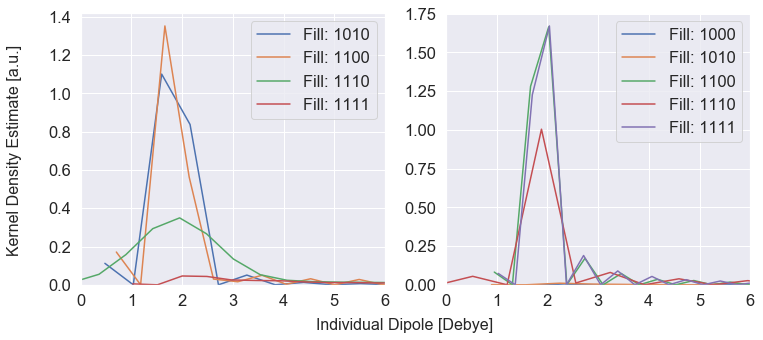

In [4]:
make_dipole_plots()

## Average Dipole vs Fill

In [5]:
def get_dipole_stats(tidy_df):    
    dipole_avgs = []
    dipole_sems = []
    fills_b = [1000,1010,1100,1110,1111]
    fills = [25,50,50,75,100]


    for fill in fills_b:
        df = filter_by_fill(fill,tidy_df)
        df_d = filter_by_type('dipole',df)
        dipole_avgs.append(np.mean(df_d.value.values))
        dipole_sems.append(np.std(df_d.value.values)/np.sqrt(len(df_d.value.values)))
        
    return fills, dipole_avgs, dipole_sems

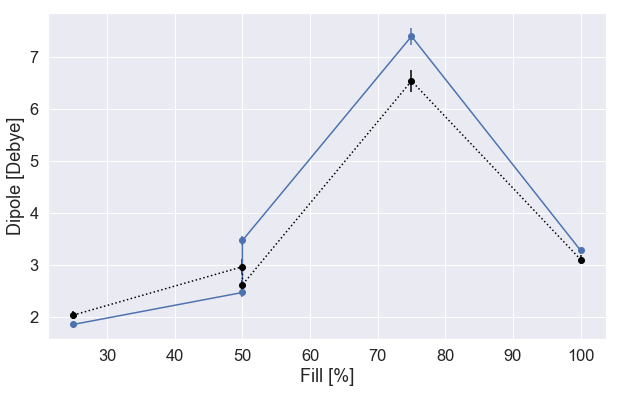

In [6]:
def plot_final_dipoles(dfs,types):
    fig = plt.figure(figsize=(10,6))
    ax = plt.gca()
    for df,type_ in zip(dfs,types):
        fills, dipole_avgs, dipole_sems = get_dipole_stats(df)
        if type_ == 'Vacuum':
            plt.errorbar(fills,dipole_avgs,yerr=dipole_sems,fmt="-o");
        else:
            plt.errorbar(fills,dipole_avgs,yerr=dipole_sems,fmt=":o",color='black');
    ax.set(xlabel="Fill [%]",ylabel="Dipole [Debye]");

plot_final_dipoles([vacuum_df,beryl_df],['Vacuum','Beryl'])

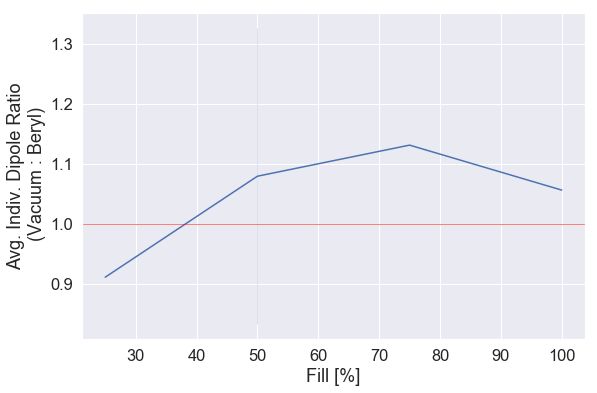

In [7]:

fig = plt.figure(figsize=(9,6))
ax = plt.gca()
dfs=[vacuum_df,beryl_df]
df1, df2 = dfs
fills, dipole_avgs1, dipole_sems1 = get_dipole_stats(df1)
fills, dipole_avgs2, dipole_sems2 = get_dipole_stats(df2)
sns.lineplot(x=fills,y=np.array(dipole_avgs1)/np.array(dipole_avgs2))
ax.axhline(1.0,color='red',linewidth=0.5)
ax.set(xlabel="Fill [%]",ylabel="Avg. Indiv. Dipole Ratio\n (Vacuum : Beryl)");



In [22]:
print(df1[df1.type == 'dipole'].groupby('fill').sem().value.values)
print(df2[df2.type == 'dipole'].groupby('fill').sem().value.values)

[0.00062579 0.07759119 0.091197   0.16047921 0.06294025]
[0.084259   0.14525954 0.10016922 0.21486888 0.08389269]


## Oxygen Partial Charge vs Fill

Using formula

$$n_H = \frac{p}{2|e|r}\sec\left(\frac{\theta}{2}\right) $$

$$n_O = -2n_H$$

In [8]:
rs = {'beryl': {1000:0.9729802, 1010:0.97294, 1100:0.97294, 1110:0.97313433, 1111:0.97322214},
      'vacuum': {1000:0.97212442, 1010:0.97219, 1100:0.97219, 1110:0.97228341, 1111:0.97251894}}
thetas = {'beryl': {1000:105.35256916, 1010:105.193, 1100:105.193, 1110:105.08502018, 1111:104.80571935},
      'vacuum': {1000:104.39790132, 1010:104.36, 1100:104.36, 1110:104.18463129, 1111:104.15880562}}

def get_oxygen_pc(p,r,theta):
    return -p//r/np.cos(np.deg2rad(theta)/2)

    

In [9]:
fills = [1000,1010,1100,1110,1111]
types = ['vacuum','beryl']
dfs = [vacuum_df,beryl_df]
results = []
for type_,df in zip(types,dfs):
    fills_b, dipole_avg, dipole_sem = get_dipole_stats(df)
    for fill,p,fill_b in zip(fills,dipole_avg,fills_b):
        r = rs[type_][fill]
        theta = thetas[type_][fill]
        n = get_oxygen_pc(p,r,theta)
        results.append([fill_b,n,type_])
        
pc_df = pd.DataFrame(results,columns=['fill','oxygen_pc','type'])       
pc_df.head()

,fill,oxygen_pc,type
0,25,-3.263060,vacuum
1,50,-4.892505,vacuum
2,50,-6.523340,vacuum
3,75,-13.021024,vacuum
4,100,-6.508628,vacuum


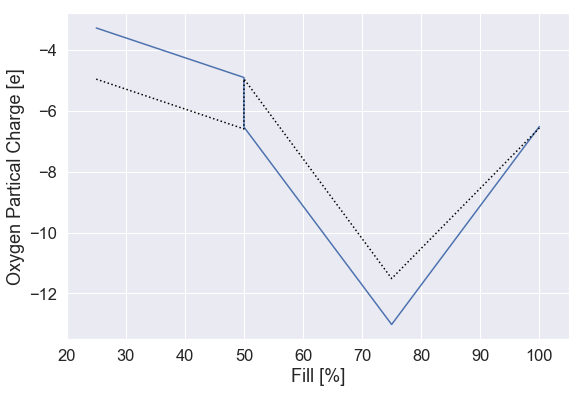

In [10]:
fig = plt.figure(figsize=(9,6))
ax = plt.gca()

#sns.lineplot(x='fill',y='oxygen_pc',data=pc_df[pc_df.type == 'vacuum'],ax=ax,label='Vacuum')
data = pc_df[pc_df.type == 'vacuum']
ax.plot(data.fill.values,data.oxygen_pc.values,label='Vacuum')
data = pc_df[pc_df.type == 'beryl']
ax.plot(data.fill.values,data.oxygen_pc.values,linestyle=':',color='black',label='Beryl')
ax.set(xlim=[20,105],xlabel='Fill [%]',ylabel='Oxygen Partical Charge [e]');
plt.legend().remove()

In [11]:
pc_df[pc_df.type == 'beryl']

,fill,oxygen_pc,type
5,25,-4.947902,beryl
6,50,-6.585182,beryl
7,50,-4.938886,beryl
8,75,-11.509890,beryl
9,100,-6.556242,beryl


In [12]:
pc_df[pc_df.type == 'vacuum']

,fill,oxygen_pc,type
0,25,-3.263060,vacuum
1,50,-4.892505,vacuum
2,50,-6.523340,vacuum
3,75,-13.021024,vacuum
4,100,-6.508628,vacuum


[Text(0, 0.5, 'Partial Charge Ratios\n(Vacuum : Beryl)'),
 Text(0.5, 0, 'Fill [%]')]

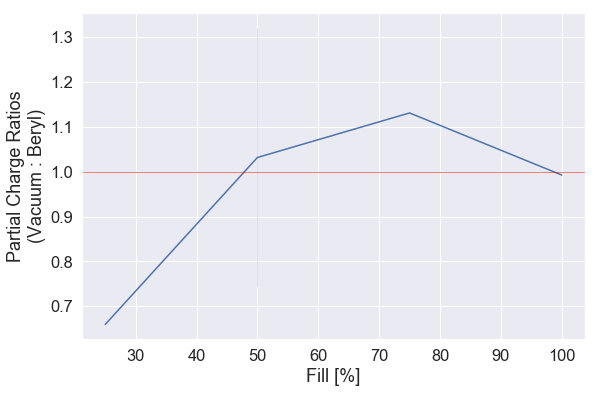

In [13]:
fig = plt.figure(figsize=(9,6))
ax = plt.gca()
data1 = pc_df[pc_df.type == 'vacuum']
data2 = pc_df[pc_df.type == 'beryl']
#ax.plot(data1.fill.values,data1.oxygen_pc.values/data2.oxygen_pc.values,marker='o',label='Vacuum')
sns.lineplot(x=data1.fill.values,y=data1.oxygen_pc.values/data2.oxygen_pc.values,markers='o')
ax.axhline(1.0,color='red',linewidth=0.5)
ax.set(xlabel='Fill [%]',ylabel='Partial Charge Ratios\n(Vacuum : Beryl)')

In [14]:
pc_df[pc_df.type == 'beryl'].oxygen_pc.values

array([ -4.94790185,  -6.58518199,  -4.93888649, -11.50988969,
        -6.55624186])